<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/DR-stage-identification/DatasetPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import shutil
import glob
import pandas as pd
import random
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Defining necessary paths

In [7]:
# Define the folder to store images
images_folder = '/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Dataset'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Define the folder for the CSV file
csv_folder = '/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset'
dataset_csv_path = os.path.join(csv_folder, 'dataset.csv')

# APTOS image directories
aptos_train_images = '/content/drive/MyDrive/DR-stage-identification/APTOS_dataset/train_images/train_images'
aptos_test_images = '/content/drive/MyDrive/DR-stage-identification/APTOS_dataset/test_images/test_images'
aptos_val_images = '/content/drive/MyDrive/DR-stage-identification/APTOS_dataset/val_images/val_images'

# APTOS CSV files (with columns: id_code, diagnosis)
aptos_train_csv = '/content/drive/MyDrive/DR-stage-identification/APTOS_dataset/train.csv'
aptos_test_csv = '/content/drive/MyDrive/DR-stage-identification/APTOS_dataset/test.csv'
aptos_valid_csv = '/content/drive/MyDrive/DR-stage-identification/APTOS_dataset/valid.csv'

# DDR image directory and CSV
DDR_images = '/content/drive/MyDrive/DR-stage-identification/DDR_dataset/DDR_dataset_extracted'
DDR_csv = '/content/drive/MyDrive/DR-stage-identification/DDR_dataset/DDR_dataset_extracted/extracted_DDR.csv'

### Copying APTOS data into our new Dataset folder

In [8]:
for folder in [aptos_train_images, aptos_test_images, aptos_val_images]:
    for img_path in glob.glob(os.path.join(folder, '*.png')):
        shutil.copy(img_path, images_folder)

### Combining the 3 APTOS csv files into one csv file

In [9]:
# Read CSVs from APTOS
df_train = pd.read_csv(aptos_train_csv)
df_test = pd.read_csv(aptos_test_csv)
df_valid = pd.read_csv(aptos_valid_csv)

# Combine them into one DataFrame
df_aptos = pd.concat([df_train, df_test, df_valid], ignore_index=True)

# Generate full file paths for each image based on id_code in the new images_folder
df_aptos['filepath'] = df_aptos['id_code'].apply(lambda x: os.path.join(images_folder, f"{x}.png"))

# Save the initial combined CSV
df_aptos.to_csv(dataset_csv_path, index=False)
print(f"Combined APTOS CSV saved to: {dataset_csv_path}")

Combined APTOS CSV saved to: /content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/dataset.csv


### Visualisation of Dataset status with just APTOS data

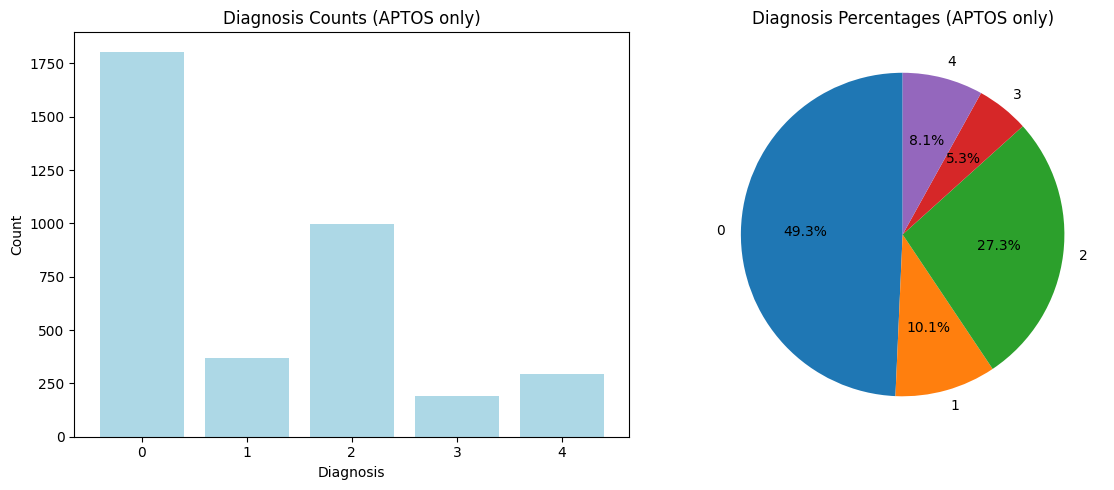

In [26]:
diagnosis_counts = df_aptos['diagnosis'].value_counts().sort_index()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(diagnosis_counts.index.astype(str), diagnosis_counts.values, color='lightblue')
plt.title('Diagnosis Counts (APTOS only)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(diagnosis_counts.values, labels=diagnosis_counts.index.astype(str),
        autopct='%1.1f%%', startangle=90)
plt.title('Diagnosis Percentages (APTOS only)')
plt.tight_layout()
plt.show()

### Copying DDR data into our Dataset folder and updating the new csv

In [13]:
# Copy all DDR images into the same images_folder
for img_path in glob.glob(os.path.join(DDR_images, '*.png')):
    shutil.copy(img_path, images_folder)

# Read the DDR CSV
df_ddr = pd.read_csv(DDR_csv)

# Update file paths for DDR images
df_ddr['filepath'] = df_ddr['id_code'].apply(lambda x: os.path.join(images_folder, f"{x}.png"))

# Combine APTOS and DDR dataframes
df_combined = pd.concat([df_aptos, df_ddr], ignore_index=True)

# Save the refreshed CSV including both APTOS and DDR entries
df_combined.to_csv(dataset_csv_path, index=False)
print(f"Refreshed CSV with APTOS and DDR entries saved to: {dataset_csv_path}")

Refreshed CSV with APTOS and DDR entries saved to: /content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/dataset.csv


### Visualisation of Dataset status with just APTOS data + DDR data

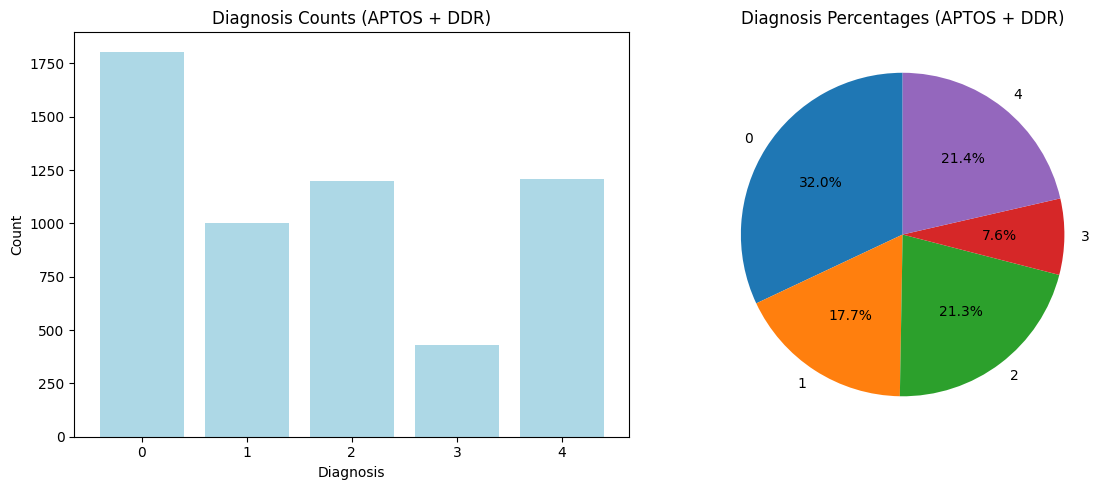

In [25]:
diagnosis_counts_combined = df_combined['diagnosis'].value_counts().sort_index()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(diagnosis_counts_combined.index.astype(str), diagnosis_counts_combined.values, color='lightblue')
plt.title('Diagnosis Counts (APTOS + DDR)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(diagnosis_counts_combined.values, labels=diagnosis_counts_combined.index.astype(str),
        autopct='%1.1f%%', startangle=90)
plt.title('Diagnosis Percentages (APTOS + DDR)')
plt.tight_layout()
plt.show()

### Removing 600 fundus images from the dataset with diagnosis "0" and updating the new csv

In [27]:
# Filter the rows with diagnosis 0
diagnosis0_df = df_combined[df_combined['diagnosis'] == 0]

if len(diagnosis0_df) >= 600:
    # Randomly select 600 indices among the images with diagnosis 0
    remove_indices = random.sample(list(diagnosis0_df.index), 600)

    # Remove the corresponding image files from disk
    for idx in remove_indices:
        file_to_remove = df_combined.loc[idx, 'filepath']
        if os.path.exists(file_to_remove):
            os.remove(file_to_remove)

    # Drop the selected rows from the DataFrame
    df_final = df_combined.drop(remove_indices).reset_index(drop=True)

    # Save the updated CSV after removal
    df_final.to_csv(dataset_csv_path, index=False)
    print(f"After removing 600 diagnosis 0 entries, the updated CSV is saved to: {dataset_csv_path}")
else:
    print("Not enough images with diagnosis 0 to remove 600 entries.")

After removing 600 diagnosis 0 entries, the updated CSV is saved to: /content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/dataset.csv


### Visualisation of Dataset status after removing 600 fundus images from diagnosis "0"

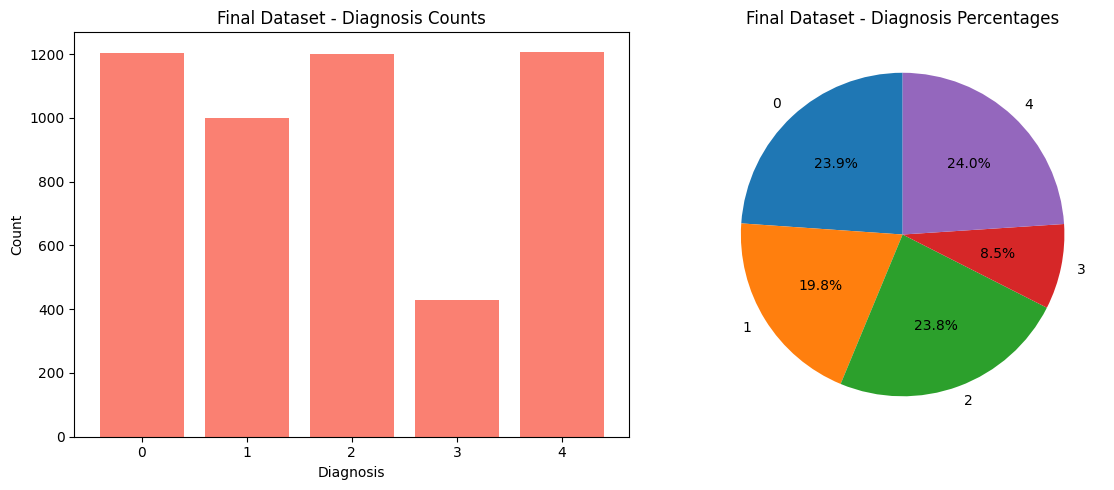

In [29]:
diagnosis_counts_final = df_final['diagnosis'].value_counts().sort_index()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(diagnosis_counts_final.index.astype(str), diagnosis_counts_final.values, color='salmon')
plt.title('Final Dataset - Diagnosis Counts')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(diagnosis_counts_final.values, labels=diagnosis_counts_final.index.astype(str),
        autopct='%1.1f%%', startangle=90)
plt.title('Final Dataset - Diagnosis Percentages')
plt.tight_layout()
plt.show()